<a href="https://colab.research.google.com/github/M7xm6/temp_llama/blob/main/Llama_2_7b_chat_hf4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 78.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


## Local Inference on GPU
Model page: https://huggingface.co/meta-llama/Llama-2-7b-chat-hf

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

The model you are trying to use is gated. Please make sure you have access to it by visiting the model page.To run inference, either set HF_TOKEN in your environment variables/ Secrets or run the following cell to login. 🤗

In [ ]:
from huggingface_hub import login
login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving deepseek_experiment_raw.csv to deepseek_experiment_raw.csv


In [ ]:
# ============================================================
# 分析前N步平均EOS概率与最终tokens消耗的相关性
# 直接在Colab cell中运行
# ============================================================

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*70)
print("📊 分析EOS概率与tokens消耗的相关性")
print("="*70)

# ============================================================
# STEP 1: 加载数据和模型
# ============================================================

print("\n📂 加载DeepSeek实验数据...")
df_deepseek = pd.read_csv('deepseek_experiment_raw.csv')
print(f"✅ 加载 {len(df_deepseek)} 条数据")

# 检查模型是否已加载
try:
    _ = model.device
    print("\n✅ 检测到已加载的Llama2模型")
except:
    print("\n🤖 加载Llama2模型...")
    model_name = "meta-llama/Llama-2-7b-chat-hf"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        low_cpu_mem_usage=True
    )
    print("✅ 模型加载完成!")

device = model.device
print(f"🔧 设备: {device}")

# ============================================================
# STEP 2: 定义生成函数(记录每步的EOS概率)
# ============================================================

def generate_with_eos_tracking(question, max_new_tokens=2048, track_steps=[20, 100]):
    """
    生成回答并追踪每步的EOS概率

    返回:
        answer: 生成的回答
        total_tokens: 总tokens数
        duration: 生成时长
        eos_probs: 所有步骤的EOS概率列表
        avg_eos_first_N: 字典 {20: 前20步平均EOS, 100: 前100步平均EOS}
    """
    # 构建prompt
    prompt = f"<s>[INST] {question} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    prompt_tokens = inputs['input_ids'].shape[1]

    # 记录EOS概率
    eos_probs = []
    eos_token_id = tokenizer.eos_token_id

    # 生成
    torch.cuda.synchronize() if device.type == "cuda" else None
    start_time = time.time()

    with torch.no_grad():
        # 使用低级API逐步生成以记录每步的logits
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        generated_tokens = []

        for step in range(max_new_tokens):
            # 前向传播
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                use_cache=True
            )

            # 获取最后一个token的logits
            next_token_logits = outputs.logits[:, -1, :]

            # 计算概率分布
            probs = torch.softmax(next_token_logits, dim=-1)
            eos_prob = probs[0, eos_token_id].item()
            eos_probs.append(eos_prob)

            # 采样下一个token
            next_token = torch.multinomial(
                torch.softmax(next_token_logits / 0.7, dim=-1),
                num_samples=1
            )

            generated_tokens.append(next_token.item())

            # 如果生成了EOS token,停止
            if next_token.item() == eos_token_id:
                break

            # 更新输入
            input_ids = torch.cat([input_ids, next_token], dim=1)
            attention_mask = torch.cat([
                attention_mask,
                torch.ones((1, 1), dtype=attention_mask.dtype, device=device)
            ], dim=1)

    torch.cuda.synchronize() if device.type == "cuda" else None
    duration = time.time() - start_time

    # 解码答案
    full_output = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    prompt_text = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
    answer = full_output[len(prompt_text):].strip()

    total_tokens = len(generated_tokens) + prompt_tokens

    # 计算前N步的平均EOS概率
    avg_eos_first_N = {}
    for N in track_steps:
        if len(eos_probs) >= N:
            avg_eos_first_N[N] = np.mean(eos_probs[:N])
        else:
            # 不足N步时，使用全部步数的平均（“有多少写多少”）
            avg_eos_first_N[N] = np.mean(eos_probs) if eos_probs else 0.0

    # 清理显存
    if device.type == "cuda":
        torch.cuda.empty_cache()

    return answer, total_tokens, duration, eos_probs, avg_eos_first_N

# ============================================================
# STEP 3: 运行实验
# ============================================================

print("\n🔬 开始运行实验(记录EOS概率)...")
print("="*70)

results = []

for idx, row in tqdm(df_deepseek.iterrows(), total=len(df_deepseek), desc="推理进度"):
    question = row['question']

    print(f"\n[{idx+1}/{len(df_deepseek)}] {question[:60]}...")

    try:
        answer, total_tok, dur, eos_probs, avg_eos = generate_with_eos_tracking(
            question,
            max_new_tokens=2048,
            track_steps=[20, 100]  # 修改为[20,100]
        )

        result = {
            'question_idx': idx,
            'question': question,
            # Llama2数据
            'llama2_total_tokens': total_tok,
            'llama2_duration_sec': dur,
            'llama2_generation_steps': len(eos_probs),
            'llama2_avg_eos_first_20': avg_eos.get(20, np.nan),
            'llama2_avg_eos_first_100': avg_eos.get(100, np.nan),  # 修改列名
            'llama2_avg_eos_all': np.mean(eos_probs),
            'llama2_max_eos': np.max(eos_probs),
            'llama2_min_eos': np.min(eos_probs),
            # DeepSeek数据
            'deepseek_total_tokens': row['total_tokens'],
            'deepseek_duration_sec': row['duration_sec'],
            'deepseek_completion_tokens': row['completion_tokens'],
        }

        results.append(result)

        print(f"  ✅ Tokens: {total_tok}, 步数: {len(eos_probs)}, "
              f"前20步EOS: {avg_eos.get(20, 0):.4f}, 前100步EOS: {avg_eos.get(100, 0):.4f}")  # 修改显示

    except Exception as e:
        print(f"  ❌ 错误: {e}")
        continue

df_results = pd.DataFrame(results)
print(f"\n✅ 实验完成! 成功处理 {len(df_results)} 个问题")

# 保存结果
df_results.to_csv('eos_analysis_results.csv', index=False)
print("💾 结果已保存: eos_analysis_results.csv")

# ============================================================
# STEP 4: 相关性分析
# ============================================================

print("\n" + "="*70)
print("📊 相关性分析")
print("="*70)

# 定义要分析的变量对（已将40替换为100）
analysis_pairs = [
    # (X变量, Y变量, X标签, Y标签)
    ('llama2_avg_eos_first_20', 'llama2_total_tokens', '前20步平均EOS', 'Llama2总tokens'),
    ('llama2_avg_eos_first_100', 'llama2_total_tokens', '前100步平均EOS', 'Llama2总tokens'),  # 修改
    ('llama2_avg_eos_first_20', 'llama2_duration_sec', '前20步平均EOS', 'Llama2时长(秒)'),
    ('llama2_avg_eos_first_100', 'llama2_duration_sec', '前100步平均EOS', 'Llama2时长(秒)'),    # 修改
    ('llama2_avg_eos_first_20', 'deepseek_total_tokens', '前20步平均EOS', 'DeepSeek总tokens'),
    ('llama2_avg_eos_first_100', 'deepseek_total_tokens', '前100步平均EOS', 'DeepSeek总tokens'),  # 修改
    ('llama2_avg_eos_first_20', 'deepseek_duration_sec', '前20步平均EOS', 'DeepSeek时长(秒)'),
    ('llama2_avg_eos_first_100', 'deepseek_duration_sec', '前100步平均EOS', 'DeepSeek时长(秒)'),  # 修改
]

correlation_results = []

for x_col, y_col, x_label, y_label in analysis_pairs:
    # 移除NaN值
    valid_mask = df_results[[x_col, y_col]].notna().all(axis=1)
    x = df_results.loc[valid_mask, x_col].values
    y = df_results.loc[valid_mask, y_col].values

    if len(x) < 3:
        continue

    # Pearson相关
    pearson_r, pearson_p = stats.pearsonr(x, y)

    # Spearman相关
    spearman_r, spearman_p = stats.spearmanr(x, y)

    # 线性回归
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    correlation_results.append({
        'x_variable': x_label,
        'y_variable': y_label,
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'r_squared': r_value**2,
        'slope': slope,
        'intercept': intercept,
        'n_samples': len(x)
    })

    print(f"\n📈 {x_label} vs {y_label}")
    print("-" * 70)
    print(f"  样本数: {len(x)}")
    print(f"  Pearson  r = {pearson_r:7.4f}  (p={pearson_p:.4e})")
    print(f"  Spearman ρ = {spearman_r:7.4f}  (p={spearman_p:.4e})")
    print(f"  R² = {r_value**2:.4f}")
    print(f"  回归方程: y = {slope:.4f}x + {intercept:.4f}")

    # 判断相关强度
    abs_r = abs(pearson_r)
    if abs_r > 0.7:
        strength = "✅ 强相关"
    elif abs_r > 0.4:
        strength = "⚠️ 中等相关"
    else:
        strength = "❌ 弱相关"
    print(f"  {strength}")

df_corr = pd.DataFrame(correlation_results)
df_corr.to_csv('correlation_summary.csv', index=False)
print(f"\n💾 相关性摘要已保存: correlation_summary.csv")

📊 分析EOS概率与tokens消耗的相关性

📂 加载DeepSeek实验数据...
✅ 加载 98 条数据

✅ 检测到已加载的Llama2模型
🔧 设备: cuda:0

🔬 开始运行实验(记录EOS概率)...


推理进度:   0%|          | 0/98 [00:00<?, ?it/s]


[1/98] 设 G 是一个有 n 个顶点（n≥2）的简单图。证明：如果对于 G 中任意两个不相邻的顶点 u 和 v，都有 deg(u...
  ✅ Tokens: 503, 步数: 402, 前20步EOS: 0.0000, 前100步EOS: 0.0000

[2/98] 考虑一个 m 行 n 列的矩形网格图（顶点坐标为 (i,j)，1≤i≤m，1≤j≤n，相邻当且仅当坐标差一个为 1）。证...
  ✅ Tokens: 574, 步数: 404, 前20步EOS: 0.0000, 前100步EOS: 0.0000

[3/98] 构造一个最小度数为 2 的简单连通图，使其没有哈密顿路径（要求顶点数尽可能少），并证明你构造的图确实没有哈密顿路径。...
  ✅ Tokens: 717, 步数: 629, 前20步EOS: 0.0000, 前100步EOS: 0.0000

[4/98] 求在 1 到 1000 中，有多少个数的十进制表示中各位数字之和等于 10？（数位DP典型问题，代替文档中的图）...
  ✅ Tokens: 656, 步数: 585, 前20步EOS: 0.0000, 前100步EOS: 0.0000

[5/98] 一棵树，每个节点有颜色（红/蓝），要求选出若干节点使得任意两个红色节点不相邻，且蓝色节点连通，求方案数。...
  ✅ Tokens: 523, 步数: 443, 前20步EOS: 0.0000, 前100步EOS: 0.0000

[6/98] 给定一个数字序列 {1, 3, 5, 6, 7, 10, 14, 19}，可以在任意位置插入加号或乘号，求所有可能表达式...
  ✅ Tokens: 606, 步数: 528, 前20步EOS: 0.0000, 前100步EOS: 0.0000

[7/98] 一个游戏有 n 个格子围成一个环，编号 0,1,…,n-1。玩家从格子 0 开始，每次随机向前或向后走 1 步（概率各 ...
  ✅ Tokens: 601, 步数: 457, 前20步EOS: 0.0000, 前100步EOS: 0.0000

[8/98] 迷宫有 n 个房间和 m 条单向通道。从房间 1 出发，每次从当前房间的出边中等概率选择一条走到下一个房间。某些房间是陷...
  ✅ Tokens: 976, 步

📊 分析EOS概率与tokens消耗的相关性（含首次非零步数）

📂 加载DeepSeek实验数据...
✅ 加载 98 条数据

✅ 检测到已加载的Llama2模型
🔧 设备: cuda:0

🔬 开始运行实验(记录EOS概率，含首次非零步数)...


推理进度:   0%|          | 0/98 [00:00<?, ?it/s]


[1/98] 设 G 是一个有 n 个顶点（n≥2）的简单图。证明：如果对于 G 中任意两个不相邻的顶点 u 和 v，都有 deg(u...
  ✅ Tokens: 508, 步数: 407, 首次非零步: 1, 非零后20步平均EOS: 0.0000

[2/98] 考虑一个 m 行 n 列的矩形网格图（顶点坐标为 (i,j)，1≤i≤m，1≤j≤n，相邻当且仅当坐标差一个为 1）。证...
  ✅ Tokens: 1142, 步数: 972, 首次非零步: 10, 非零后20步平均EOS: 0.0000

[3/98] 构造一个最小度数为 2 的简单连通图，使其没有哈密顿路径（要求顶点数尽可能少），并证明你构造的图确实没有哈密顿路径。...
  ✅ Tokens: 464, 步数: 376, 首次非零步: 25, 非零后20步平均EOS: 0.0000

[4/98] 求在 1 到 1000 中，有多少个数的十进制表示中各位数字之和等于 10？（数位DP典型问题，代替文档中的图）...
  ✅ Tokens: 586, 步数: 515, 首次非零步: 20, 非零后20步平均EOS: 0.0000

[5/98] 一棵树，每个节点有颜色（红/蓝），要求选出若干节点使得任意两个红色节点不相邻，且蓝色节点连通，求方案数。...
  ✅ Tokens: 481, 步数: 401, 首次非零步: 22, 非零后20步平均EOS: 0.0000

[6/98] 给定一个数字序列 {1, 3, 5, 6, 7, 10, 14, 19}，可以在任意位置插入加号或乘号，求所有可能表达式...
  ✅ Tokens: 716, 步数: 638, 首次非零步: 10, 非零后20步平均EOS: 0.0000

[7/98] 一个游戏有 n 个格子围成一个环，编号 0,1,…,n-1。玩家从格子 0 开始，每次随机向前或向后走 1 步（概率各 ...
  ✅ Tokens: 672, 步数: 528, 首次非零步: 7, 非零后20步平均EOS: 0.0000

[8/98] 迷宫有 n 个房间和 m 条单向通道。从房间 1 出发，每次从当前房间的出边中等概率选择一条走到下一个房间。某些房间是陷...
  ✅ Tokens: 1096, 步数: 926, 首次非零步: 7, 非零后

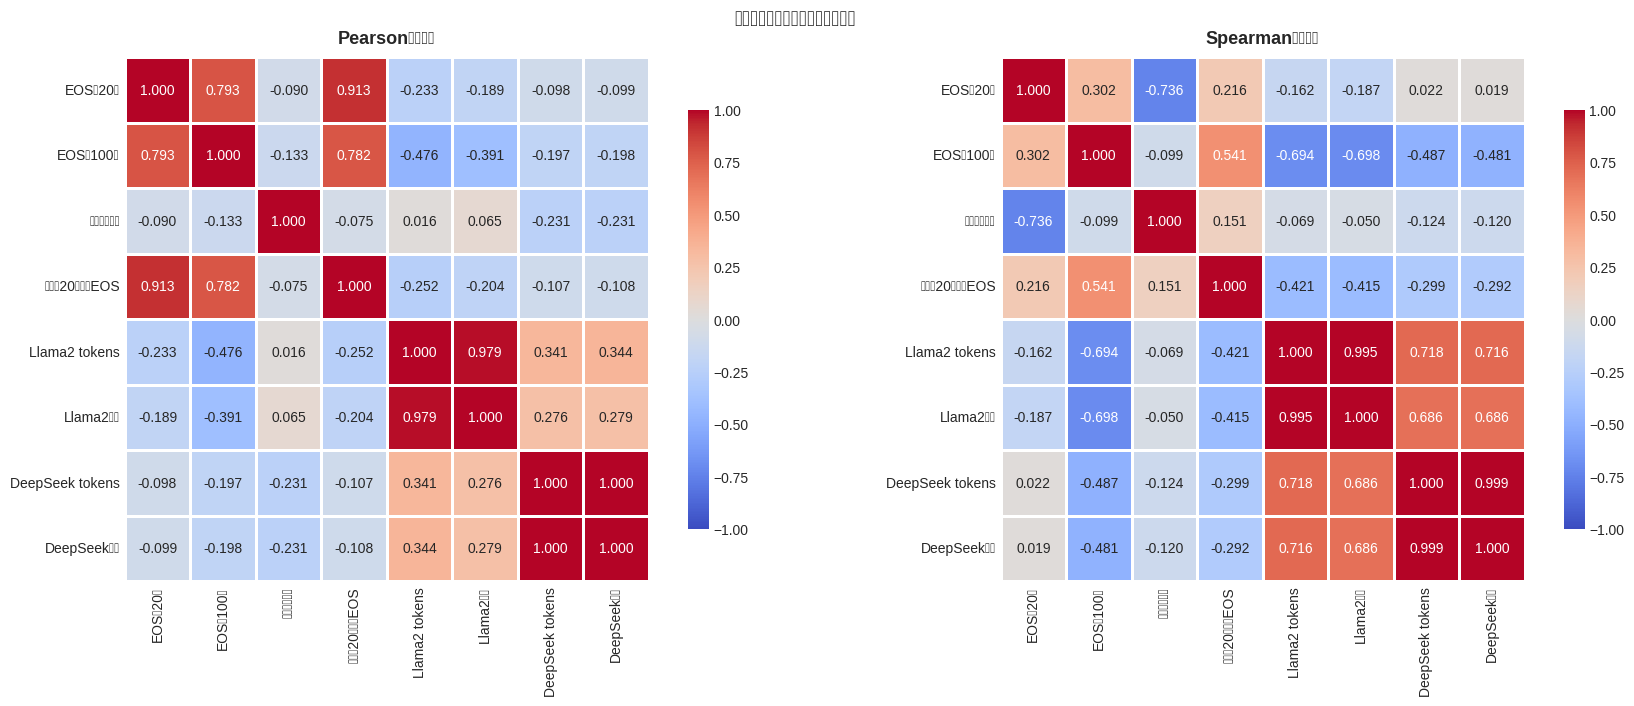


🎉 分析完成! 新增指标已包含在结果文件和相关热力图中。


In [ ]:
# ============================================================
# 分析前N步平均EOS概率与最终tokens消耗的相关性
# 新增：首次非零EOS步数 和 非零后前20步平均EOS
# ============================================================

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*70)
print("📊 分析EOS概率与tokens消耗的相关性（含首次非零步数）")
print("="*70)

# ============================================================
# STEP 1: 加载数据和模型
# ============================================================

print("\n📂 加载DeepSeek实验数据...")
df_deepseek = pd.read_csv('deepseek_experiment_raw.csv')
print(f"✅ 加载 {len(df_deepseek)} 条数据")

# 检查模型是否已加载
try:
    _ = model.device
    print("\n✅ 检测到已加载的Llama2模型")
except:
    print("\n🤖 加载Llama2模型...")
    model_name = "meta-llama/Llama-2-7b-chat-hf"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        low_cpu_mem_usage=True
    )
    print("✅ 模型加载完成!")

device = model.device
print(f"🔧 设备: {device}")

# ============================================================
# STEP 2: 定义生成函数(记录每步的EOS概率，新增指标)
# ============================================================

def generate_with_eos_tracking(question, max_new_tokens=2048, track_steps=[20, 100]):
    """
    生成回答并追踪每步的EOS概率

    返回:
        answer: 生成的回答
        total_tokens: 总tokens数
        duration: 生成时长
        eos_probs: 所有步骤的EOS概率列表
        avg_eos_first_N: 字典 {20: 前20步平均EOS, 100: 前100步平均EOS}
        first_nonzero_step: 首次EOS概率>0的步数索引（从0开始）
        avg_eos_after_nonzero: 从首次非零步开始最多20步的平均EOS
    """
    # 构建prompt
    prompt = f"<s>[INST] {question} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    prompt_tokens = inputs['input_ids'].shape[1]

    # 记录EOS概率
    eos_probs = []
    eos_token_id = tokenizer.eos_token_id

    # 生成
    torch.cuda.synchronize() if device.type == "cuda" else None
    start_time = time.time()

    with torch.no_grad():
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        generated_tokens = []

        for step in range(max_new_tokens):
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                use_cache=True
            )

            next_token_logits = outputs.logits[:, -1, :]
            probs = torch.softmax(next_token_logits, dim=-1)
            eos_prob = probs[0, eos_token_id].item()
            eos_probs.append(eos_prob)

            next_token = torch.multinomial(
                torch.softmax(next_token_logits / 0.7, dim=-1),
                num_samples=1
            )
            generated_tokens.append(next_token.item())

            if next_token.item() == eos_token_id:
                break

            input_ids = torch.cat([input_ids, next_token], dim=1)
            attention_mask = torch.cat([
                attention_mask,
                torch.ones((1, 1), dtype=attention_mask.dtype, device=device)
            ], dim=1)

    torch.cuda.synchronize() if device.type == "cuda" else None
    duration = time.time() - start_time

    # 解码答案
    full_output = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    prompt_text = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
    answer = full_output[len(prompt_text):].strip()

    total_tokens = len(generated_tokens) + prompt_tokens

    # 计算前N步的平均EOS概率
    avg_eos_first_N = {}
    for N in track_steps:
        if len(eos_probs) >= N:
            avg_eos_first_N[N] = np.mean(eos_probs[:N])
        else:
            avg_eos_first_N[N] = np.mean(eos_probs) if eos_probs else 0.0

    # === 新增指标：首次非零EOS步数 和 非零后前20步平均EOS ===
    nonzero_indices = [i for i, p in enumerate(eos_probs) if p > 0]
    if nonzero_indices:
        first_nonzero_step = nonzero_indices[0]
        start = first_nonzero_step
        end = min(start + 20, len(eos_probs))
        avg_after_nonzero = np.mean(eos_probs[start:end])
    else:
        first_nonzero_step = np.nan
        avg_after_nonzero = np.nan
    # ======================================================

    # 清理显存
    if device.type == "cuda":
        torch.cuda.empty_cache()

    return answer, total_tokens, duration, eos_probs, avg_eos_first_N, first_nonzero_step, avg_after_nonzero

# ============================================================
# STEP 3: 运行实验
# ============================================================

print("\n🔬 开始运行实验(记录EOS概率，含首次非零步数)...")
print("="*70)

results = []

for idx, row in tqdm(df_deepseek.iterrows(), total=len(df_deepseek), desc="推理进度"):
    question = row['question']

    print(f"\n[{idx+1}/{len(df_deepseek)}] {question[:60]}...")

    try:
        answer, total_tok, dur, eos_probs, avg_eos, first_nonzero, avg_after = generate_with_eos_tracking(
            question,
            max_new_tokens=2048,
            track_steps=[20, 100]
        )

        result = {
            'question_idx': idx,
            'question': question,
            # Llama2数据
            'llama2_total_tokens': total_tok,
            'llama2_duration_sec': dur,
            'llama2_generation_steps': len(eos_probs),
            'llama2_avg_eos_first_20': avg_eos.get(20, np.nan),
            'llama2_avg_eos_first_100': avg_eos.get(100, np.nan),
            'llama2_avg_eos_all': np.mean(eos_probs),
            'llama2_max_eos': np.max(eos_probs),
            'llama2_min_eos': np.min(eos_probs),
            # 新增指标
            'llama2_first_nonzero_eos_step': first_nonzero,
            'llama2_avg_eos_first20_after_nonzero': avg_after,
            # DeepSeek数据
            'deepseek_total_tokens': row['total_tokens'],
            'deepseek_duration_sec': row['duration_sec'],
            'deepseek_completion_tokens': row['completion_tokens'],
        }

        results.append(result)

        print(f"  ✅ Tokens: {total_tok}, 步数: {len(eos_probs)}, "
              f"首次非零步: {first_nonzero}, "
              f"非零后20步平均EOS: {avg_after:.4f}")

    except Exception as e:
        print(f"  ❌ 错误: {e}")
        continue

df_results = pd.DataFrame(results)
print(f"\n✅ 实验完成! 成功处理 {len(df_results)} 个问题")

# 保存结果
df_results.to_csv('eos_analysis_results.csv', index=False)
print("💾 结果已保存: eos_analysis_results.csv")

# ============================================================
# STEP 4: 相关性分析（含新增指标）
# ============================================================

print("\n" + "="*70)
print("📊 相关性分析（含新增指标）")
print("="*70)

# 定义要分析的变量对（添加新指标与各Y变量的组合）
analysis_pairs = [
    # 原有指标
    ('llama2_avg_eos_first_20', 'llama2_total_tokens', '前20步平均EOS', 'Llama2总tokens'),
    ('llama2_avg_eos_first_100', 'llama2_total_tokens', '前100步平均EOS', 'Llama2总tokens'),
    ('llama2_avg_eos_first_20', 'llama2_duration_sec', '前20步平均EOS', 'Llama2时长(秒)'),
    ('llama2_avg_eos_first_100', 'llama2_duration_sec', '前100步平均EOS', 'Llama2时长(秒)'),
    ('llama2_avg_eos_first_20', 'deepseek_total_tokens', '前20步平均EOS', 'DeepSeek总tokens'),
    ('llama2_avg_eos_first_100', 'deepseek_total_tokens', '前100步平均EOS', 'DeepSeek总tokens'),
    ('llama2_avg_eos_first_20', 'deepseek_duration_sec', '前20步平均EOS', 'DeepSeek时长(秒)'),
    ('llama2_avg_eos_first_100', 'deepseek_duration_sec', '前100步平均EOS', 'DeepSeek时长(秒)'),

    # 新增指标：首次非零步数
    ('llama2_first_nonzero_eos_step', 'llama2_total_tokens', '首次非零EOS步数', 'Llama2总tokens'),
    ('llama2_first_nonzero_eos_step', 'llama2_duration_sec', '首次非零EOS步数', 'Llama2时长(秒)'),
    ('llama2_first_nonzero_eos_step', 'deepseek_total_tokens', '首次非零EOS步数', 'DeepSeek总tokens'),
    ('llama2_first_nonzero_eos_step', 'deepseek_duration_sec', '首次非零EOS步数', 'DeepSeek时长(秒)'),

    # 新增指标：非零后前20步平均EOS
    ('llama2_avg_eos_first20_after_nonzero', 'llama2_total_tokens', '非零后前20步平均EOS', 'Llama2总tokens'),
    ('llama2_avg_eos_first20_after_nonzero', 'llama2_duration_sec', '非零后前20步平均EOS', 'Llama2时长(秒)'),
    ('llama2_avg_eos_first20_after_nonzero', 'deepseek_total_tokens', '非零后前20步平均EOS', 'DeepSeek总tokens'),
    ('llama2_avg_eos_first20_after_nonzero', 'deepseek_duration_sec', '非零后前20步平均EOS', 'DeepSeek时长(秒)'),
]

correlation_results = []

for x_col, y_col, x_label, y_label in analysis_pairs:
    valid_mask = df_results[[x_col, y_col]].notna().all(axis=1)
    x = df_results.loc[valid_mask, x_col].values
    y = df_results.loc[valid_mask, y_col].values

    if len(x) < 3:
        continue

    pearson_r, pearson_p = stats.pearsonr(x, y)
    spearman_r, spearman_p = stats.spearmanr(x, y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    correlation_results.append({
        'x_variable': x_label,
        'y_variable': y_label,
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'r_squared': r_value**2,
        'slope': slope,
        'intercept': intercept,
        'n_samples': len(x)
    })

    print(f"\n📈 {x_label} vs {y_label}")
    print("-" * 70)
    print(f"  样本数: {len(x)}")
    print(f"  Pearson  r = {pearson_r:7.4f}  (p={pearson_p:.4e})")
    print(f"  Spearman ρ = {spearman_r:7.4f}  (p={spearman_p:.4e})")
    print(f"  R² = {r_value**2:.4f}")

    abs_r = abs(pearson_r)
    if abs_r > 0.7:
        strength = "✅ 强相关"
    elif abs_r > 0.4:
        strength = "⚠️ 中等相关"
    else:
        strength = "❌ 弱相关"
    print(f"  {strength}")

df_corr = pd.DataFrame(correlation_results)
df_corr.to_csv('correlation_summary.csv', index=False)
print(f"\n💾 相关性摘要已保存: correlation_summary.csv")

# ============================================================
# STEP 5: 可视化（更新热力图，包含新增指标）
# ============================================================

print("\n📊 生成可视化图表（含新增指标）...")

# 选择关键指标（包含新增的两个）
key_metrics = [
    'llama2_avg_eos_first_20',
    'llama2_avg_eos_first_100',
    'llama2_first_nonzero_eos_step',
    'llama2_avg_eos_first20_after_nonzero',
    'llama2_total_tokens',
    'llama2_duration_sec',
    'deepseek_total_tokens',
    'deepseek_duration_sec'
]

metric_labels = {
    'llama2_avg_eos_first_20': 'EOS前20步',
    'llama2_avg_eos_first_100': 'EOS前100步',
    'llama2_first_nonzero_eos_step': '首次非零步数',
    'llama2_avg_eos_first20_after_nonzero': '非零后20步平均EOS',
    'llama2_total_tokens': 'Llama2 tokens',
    'llama2_duration_sec': 'Llama2时长',
    'deepseek_total_tokens': 'DeepSeek tokens',
    'deepseek_duration_sec': 'DeepSeek时长'
}

# 绘制双热力图
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('相关性对比热力图（含新增指标）', fontsize=16, fontweight='bold')

# Pearson
corr_pearson = df_results[key_metrics].corr(method='pearson')
corr_pearson.index = [metric_labels[m] for m in corr_pearson.index]
corr_pearson.columns = [metric_labels[m] for m in corr_pearson.columns]
sns.heatmap(corr_pearson, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Pearson相关系数', fontsize=13, fontweight='bold', pad=10)

# Spearman
corr_spearman = df_results[key_metrics].corr(method='spearman')
corr_spearman.index = [metric_labels[m] for m in corr_spearman.index]
corr_spearman.columns = [metric_labels[m] for m in corr_spearman.columns]
sns.heatmap(corr_spearman, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title('Spearman相关系数', fontsize=13, fontweight='bold', pad=10)

plt.tight_layout()
plt.savefig('correlation_heatmap_with_nonzero.png', dpi=300, bbox_inches='tight')
print("✅ 保存图表: correlation_heatmap_with_nonzero.png")
plt.show()

# 可选：绘制新增指标与tokens的散点图（略，可根据需要自行添加）

print("\n🎉 分析完成! 新增指标已包含在结果文件和相关热力图中。")